In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mne
import seaborn as sns
import os
%load_ext autoreload
%autoreload 2

In [199]:
SLEEP_EPOCH_S = 30

SORTED_IDS = []
for file in sorted(os.listdir('files')):
    if file.endswith("_respevt.txt"):
        SORTED_IDS.append(int(file[5:8]))
print(SORTED_IDS)

DATA_DIR = "rafael data download/merged"

# NOTE: the "path_id" from the file naming convention is 0,1,..,25
def get_path(path_id):
    return f"{DATA_DIR}/patient_{path_id}.gzip"

def get_patient_id(path_id):
    return SORTED_IDS[path_id]

def get_path_id(patient_id):
    return SORTED_IDS.index(patient_id)

[2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [46]:
def read_respevt_txt_to_df(filename):
    respevt_time = []
    respevt_type = []
    respevt_pb_cs = []
    respevt_duration = []
    respevt_desat_low = []
    respevt_desat_drop = []
    respevt_snore = []
    respevt_arousal = []
    respevt_bt_rate = []
    respevt_bt_change = []
    for line_no, line in enumerate(open(filename).readlines()):
        if line_no > 2:
            vals = line.split()
            is_pb = False
            is_no_desaturation = False
            for count, val in enumerate(vals):
                if count == 0 and val != '\x1a':
                    respevt_time.append(val)
                elif count == 1 and val == 'PB':
                    is_pb = True
                    respevt_type.append(val)
                elif count == 1 and val != 'PB':
                    respevt_type.append(val)
                elif count == 2 and is_pb:
                    pass
                elif count == 2 and not is_pb:
                    respevt_pb_cs.append(np.nan)
                    respevt_duration.append(val)
                elif count == 3 and is_pb:
                    respevt_pb_cs.append(val)
                elif count == 3 and not is_pb:
                    if val == '-' or val == '+':
                        respevt_desat_low.append(np.nan)
                        respevt_desat_drop.append(np.nan)
                        respevt_snore.append(val)
                        is_no_desaturation = True
                    else:
                        respevt_desat_low.append(val)
                elif count == 4 and is_pb:
                    respevt_duration.append(val)
                elif count == 4 and not is_pb:
                    if is_no_desaturation:
                        respevt_arousal.append(val)
                    else:
                        respevt_desat_drop.append(val)
                elif count == 5 and is_pb:
                    if val == '-' or val == '+':
                        respevt_desat_low.append(np.nan)
                        respevt_desat_drop.append(np.nan)
                        respevt_snore.append(val)
                        is_no_desaturation = True
                    else:
                        respevt_desat_low.append(val)
                elif count == 5 and not is_pb:
                    if is_no_desaturation:
                        respevt_bt_rate.append(val)
                    else:
                        respevt_snore.append(val)
                elif count == 6 and is_pb:
                    if is_no_desaturation:
                        respevt_arousal.append(val)
                    else:
                        respevt_desat_drop.append(val)
                elif count == 6 and not is_pb:
                    if is_no_desaturation:
                        respevt_bt_change.append(val)
                    else:
                        respevt_arousal.append(val)
                elif count == 7 and is_pb:
                    if is_no_desaturation:
                        respevt_bt_rate.append(val)
                    else:
                        respevt_snore.append(val)
                elif count == 7 and not is_pb:
                    respevt_bt_rate.append(val)
                elif count == 8 and is_pb:
                    if is_no_desaturation:
                        respevt_bt_change.append(val)
                    else:
                        respevt_arousal.append(val)
                elif count == 8 and not is_pb:
                    respevt_bt_change.append(val)
                elif count == 9 and is_pb:
                    respevt_bt_rate.append(val)
                elif count == 10 and is_pb:
                    respevt_bt_change.append(val)
            if len(respevt_bt_rate) < len(respevt_time):
                respevt_bt_rate.append(np.nan)
            if len(respevt_bt_change) < len(respevt_time):
                respevt_bt_change.append(np.nan)
    df = pd.DataFrame(
        {
            'Time': respevt_time,
            'Type': respevt_type,
            'PB/CS': respevt_pb_cs,
            'Duration': respevt_duration,
            'DesaturationLow': respevt_desat_low,
            'Desaturation%Drop': respevt_desat_drop,
            'Snore': respevt_snore,
            'Arousal': respevt_arousal,
            'B_T_Rate': respevt_bt_rate,
            'B_T_Change': respevt_bt_change
        }
    )
    df['Time'] = pd.to_timedelta(df['Time'])
    df['Duration'] = pd.to_numeric(df['Duration'])
    df['DesaturationLow'] = pd.to_numeric(df['DesaturationLow'])
    df['Desaturation%Drop'] = pd.to_numeric(df['Desaturation%Drop'])
    df['B_T_Rate'] = pd.to_numeric(df['B_T_Rate'])
    df['B_T_Change'] = pd.to_numeric(df['B_T_Change'])
    return df


### Initial testing:

In [47]:
merge_002 = pd.read_parquet(get_path(0))
merge_002

,chan 1,chan 2,chan 3,Time,Lefteye,RightEye,EMG,C3A2,C4A1,ECG,SpO2,Sound,Flow,Sum,ribcage,abdo,BodyPos,Pulse
0,0.004501,0.004501,0.004501,0.000000,0.558730,0.566545,0.490354,0.511844,0.611477,0.423932,3.884737,-0.003663,-19.065934,-3.649084,-3.270085,-3.774115,4.906227,3.692308
1,0.004501,0.004501,0.004501,0.007812,0.598560,0.567553,0.539025,0.435653,0.550916,0.429792,0.276312,-0.003286,-19.786504,-3.670046,-3.255901,-3.831452,4.905938,1.165157
2,0.004501,0.004501,0.004501,0.015625,0.646642,0.539194,0.324298,0.359463,0.324298,0.412210,-2.728930,-0.002938,-20.381273,-3.686712,-3.242042,-3.879458,4.905700,-0.940021
3,0.004501,0.004501,0.004501,0.023438,0.696302,0.514242,0.317868,0.312576,0.377045,0.459096,-5.120093,-0.002638,-20.848625,-3.699409,-3.228670,-3.918079,4.905515,-2.615500
4,0.004501,0.004501,0.004501,0.031250,0.744322,0.533333,0.548962,0.382906,0.513797,0.513797,-6.899946,-0.002402,-21.189764,-3.708501,-3.215914,-3.947417,4.905385,-3.863121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3525115,0.007074,0.006474,0.006474,27539.960938,0.542736,0.555069,0.151438,0.439560,0.558730,0.830281,8.071763,-0.004051,-18.224023,-3.623546,-3.284407,-3.707656,4.906562,6.624123
3525116,0.007805,0.007204,0.007204,27539.968750,0.542736,0.555069,0.151438,0.439560,0.558730,0.830281,8.071763,-0.004051,-18.224023,-3.623546,-3.284407,-3.707656,4.906562,6.624123
3525117,0.007260,0.006701,0.006701,27539.976562,0.542736,0.555069,0.151438,0.439560,0.558730,0.830281,8.071763,-0.004051,-18.224023,-3.623546,-3.284407,-3.707656,4.906562,6.624123
3525118,0.005770,0.005282,0.005282,27539.984375,0.542736,0.555069,0.151438,0.439560,0.558730,0.830281,8.071763,-0.004051,-18.224023,-3.623546,-3.284407,-3.707656,4.906562,6.624123


In [48]:
stage_002 = pd.read_table("files/ucddb002_stage.txt")
stage_002['Time'] = (stage_002.index * 30).astype(float)
stage_002.rename(columns = {'0':'sleep_stage'}, inplace=True)
stage_002

,sleep_stage,Time
0,0,0.0
1,0,30.0
2,0,60.0
3,0,90.0
4,0,120.0
...,...,...
742,0,22260.0
743,0,22290.0
744,0,22320.0
745,0,22350.0


In [49]:
merge_002 = pd.merge_asof(merge_002, stage_002, on='Time', direction='nearest')
merge_002 = merge_002.set_index("Time")
merge_002.head()

,chan 1,chan 2,chan 3,Lefteye,RightEye,EMG,C3A2,C4A1,ECG,SpO2,Sound,Flow,Sum,ribcage,abdo,BodyPos,Pulse,sleep_stage
Time,,,,,,,,,,,,,,,,,,
0.000000,0.004501,0.004501,0.004501,0.558730,0.566545,0.490354,0.511844,0.611477,0.423932,3.884737,-0.003663,-19.065934,-3.649084,-3.270085,-3.774115,4.906227,3.692308,0
0.007812,0.004501,0.004501,0.004501,0.598560,0.567553,0.539025,0.435653,0.550916,0.429792,0.276312,-0.003286,-19.786504,-3.670046,-3.255901,-3.831452,4.905938,1.165157,0
0.015625,0.004501,0.004501,0.004501,0.646642,0.539194,0.324298,0.359463,0.324298,0.412210,-2.728930,-0.002938,-20.381273,-3.686712,-3.242042,-3.879458,4.905700,-0.940021,0
0.023438,0.004501,0.004501,0.004501,0.696302,0.514242,0.317868,0.312576,0.377045,0.459096,-5.120093,-0.002638,-20.848625,-3.699409,-3.228670,-3.918079,4.905515,-2.615500,0
0.031250,0.004501,0.004501,0.004501,0.744322,0.533333,0.548962,0.382906,0.513797,0.513797,-6.899946,-0.002402,-21.189764,-3.708501,-3.215914,-3.947417,4.905385,-3.863121,0


In [59]:
respevt_002 = read_respevt_txt_to_df("files/ucddb002_respevt.txt")
respevt_002['Time'] = respevt_002['Time'].dt.total_seconds()
respevt_002.head()

,Time,Type,PB/CS,Duration,DesaturationLow,Desaturation%Drop,Snore,Arousal,B_T_Rate,B_T_Change
0,1753.0,HYP-C,NaN,16,89.9,4.1,-,-,64.7,-5.7
1,3586.0,HYP-C,NaN,20,92.0,2.1,-,-,85.2,-26.2
2,3697.0,HYP-C,NaN,13,92.8,4.1,-,-,NaN,NaN
3,3745.0,HYP-C,NaN,13,NaN,NaN,-,-,NaN,NaN
4,4067.0,HYP-C,NaN,14,90.8,4.1,-,+,NaN,NaN


In [97]:
# truncate time
start_sec = 1700
step_sec = 100
end_sec = start_sec + step_sec
truncated_002 = merge_002.query(f"index >= {start_sec} and index < {end_sec}")
respevt_trunc_002 = respevt_002.query(f"Time >= {start_sec} and Time < {end_sec}")

In [98]:
respevt_trunc_002

,Time,Type,PB/CS,Duration,DesaturationLow,Desaturation%Drop,Snore,Arousal,B_T_Rate,B_T_Change
0,1753.0,HYP-C,NaN,16,89.9,4.1,-,-,64.7,-5.7


In [77]:
truncated_002.shape

(3840, 18)

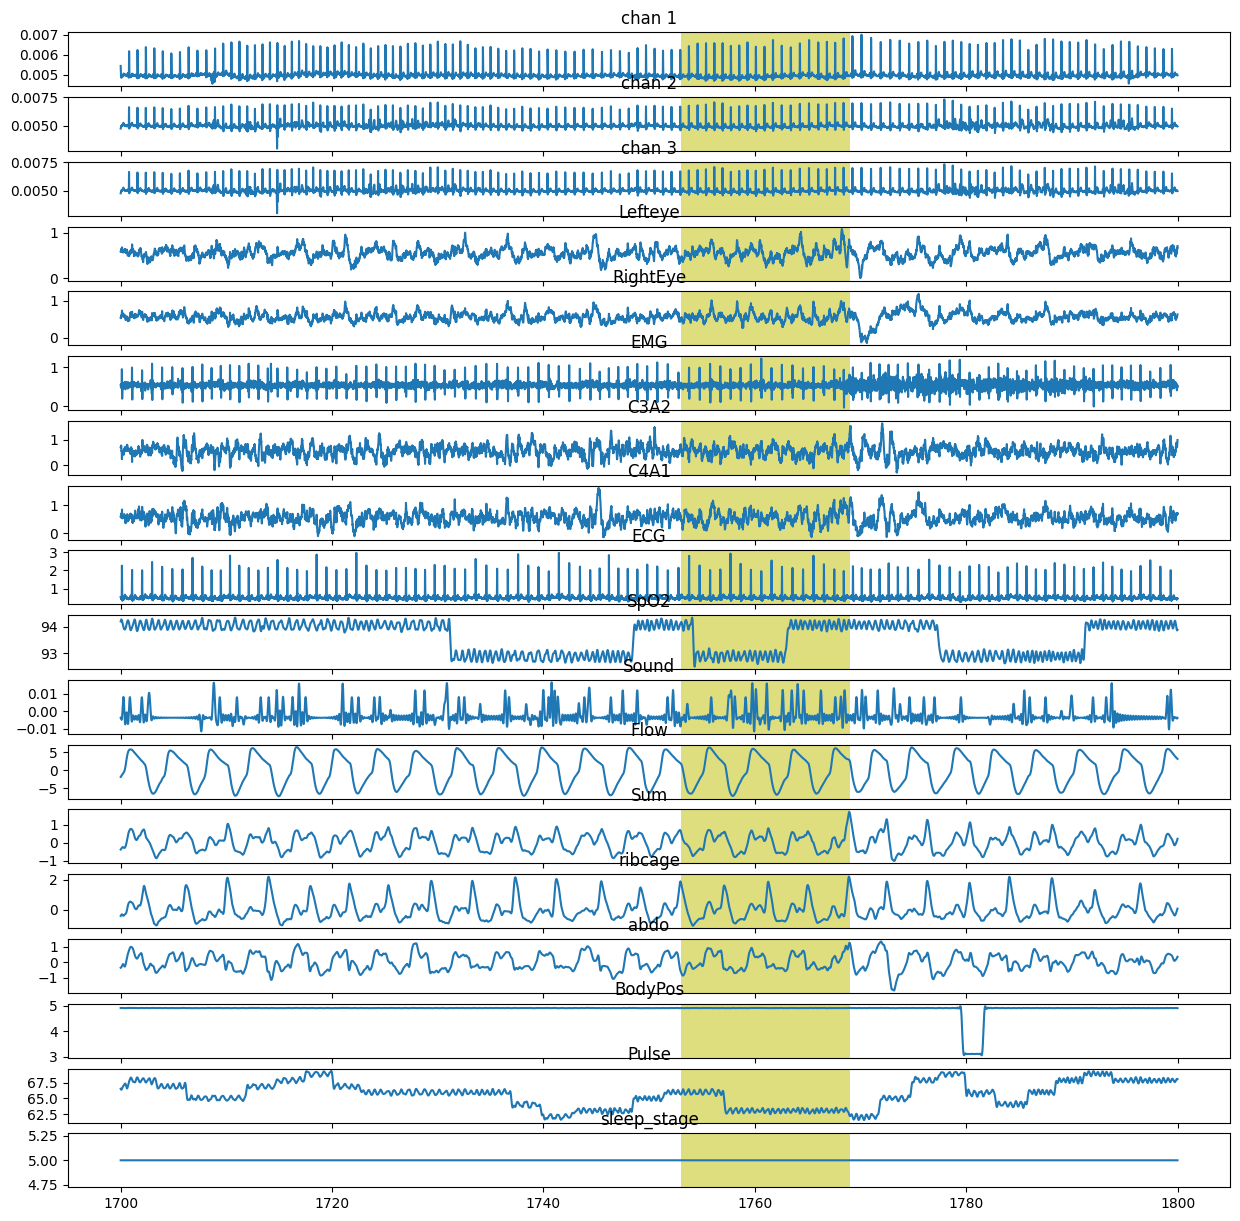

In [208]:
input_df = truncated_002
respevt_df = respevt_trunc_002
#input_df = merge_002
#respevt_df = respevt_002

n_signals = input_df.shape[1]
fig, axs = plt.subplots(n_signals, sharex=True, figsize=(15, 15))
for i in range(n_signals):
    axs[i].plot(input_df.index, input_df.iloc[:, i])
    axs[i].set_title(input_df.columns[i])
    for j in range(respevt_df.shape[0]):
        start_sec = respevt_df.iloc[j, 0]
        duration = respevt_df.iloc[j, :]['Duration']
        axs[i].axvspan(start_sec, start_sec + duration, color='y', alpha=0.5, lw=0)
plt.show()

# Data Pre-processing
1. Load data (merge, stage, and respevt)
2. Basic cleaning + joins
3. Trim start and end where `sleep_stage == 0`
4. Segment Time series into sliding windows, store time till start of next respiratory event for each window

In [182]:
def load_data_and_merge(patient_id):
    respevt_df = read_respevt_txt_to_df(f"files/ucddb{patient_id:03}_respevt.txt")
    respevt_df['Time'] = respevt_df['Time'].dt.total_seconds()

    path_id = get_path_id(patient_id)
    edf_rec_df = pd.read_parquet(get_path(path_id))

    stage_df = pd.read_table(f"files/ucddb{patient_id:03}_stage.txt")
    stage_df['Time'] = (stage_df.index * SLEEP_EPOCH_S).astype(float)
    stage_df.rename(columns = {'0':'sleep_stage'}, inplace=True)

    event_timestamps = []
    for i in range(respevt_002.shape[0]):
        start_event_time = respevt_002.iloc[i, 0]
        duration = respevt_002.iloc[i, :]['Duration']
        for j in range(duration):
            event_timestamps.append(start_event_time + j)

    is_event = np.zeros(int(event_timestamps[-1] + 2))
    for time in event_timestamps:
        is_event[int(time)] = 1
    event_df = pd.DataFrame({
        'Time': range(len(is_event)),
        'is_event': is_event
    })
    event_df['Time'] = event_df['Time'].astype(float)

    merge_df = pd.merge_asof(edf_rec_df, stage_df, on='Time', direction='nearest')
    merge_df = pd.merge_asof(merge_df, event_df, on='Time', direction='nearest')
    merge_df = merge_df.set_index("Time")

    return merge_df, respevt_df 

def trim_merge_df(merge_df):
    nonzero_idx = np.nonzero(merge_df['sleep_stage'])[0]
    first_idx = nonzero_idx[0]
    last_idx = nonzero_idx[-1]
    out_df = merge_df.iloc[first_idx:last_idx, :]
    return out_df

def get_window(start_sec, step_sec, merge_df, respevt_df, contain_event=False):
    end_sec = start_sec + step_sec
    window_df = merge_df.query(f"index >= {start_sec} and index < {end_sec}")
    window_respevt_df = respevt_df.query(f"Time >= {start_sec} and Time < {end_sec}")

    if (1 in set(window_df['is_event'])) and (contain_event == False):
        return pd.DataFrame(), pd.DataFrame(), np.nan
    
    next_respevt = respevt_df.query(f"Time >= {end_sec}")
    if next_respevt.shape[0] == 0:
        return pd.DataFrame(), pd.DataFrame(), np.nan

    next_event_time = next_respevt.iloc[0,:]['Time']
    time_to_next = next_event_time - end_sec

    return window_df, window_respevt_df, time_to_next

### example:

In [183]:
a, b = load_data_and_merge(2)
display(a.head())
display(b.head())

,chan 1,chan 2,chan 3,Lefteye,RightEye,EMG,C3A2,C4A1,ECG,SpO2,Sound,Flow,Sum,ribcage,abdo,BodyPos,Pulse,sleep_stage,is_event
Time,,,,,,,,,,,,,,,,,,,
0.000000,0.004501,0.004501,0.004501,0.558730,0.566545,0.490354,0.511844,0.611477,0.423932,3.884737,-0.003663,-19.065934,-3.649084,-3.270085,-3.774115,4.906227,3.692308,0,0.0
0.007812,0.004501,0.004501,0.004501,0.598560,0.567553,0.539025,0.435653,0.550916,0.429792,0.276312,-0.003286,-19.786504,-3.670046,-3.255901,-3.831452,4.905938,1.165157,0,0.0
0.015625,0.004501,0.004501,0.004501,0.646642,0.539194,0.324298,0.359463,0.324298,0.412210,-2.728930,-0.002938,-20.381273,-3.686712,-3.242042,-3.879458,4.905700,-0.940021,0,0.0
0.023438,0.004501,0.004501,0.004501,0.696302,0.514242,0.317868,0.312576,0.377045,0.459096,-5.120093,-0.002638,-20.848625,-3.699409,-3.228670,-3.918079,4.905515,-2.615500,0,0.0
0.031250,0.004501,0.004501,0.004501,0.744322,0.533333,0.548962,0.382906,0.513797,0.513797,-6.899946,-0.002402,-21.189764,-3.708501,-3.215914,-3.947417,4.905385,-3.863121,0,0.0


,Time,Type,PB/CS,Duration,DesaturationLow,Desaturation%Drop,Snore,Arousal,B_T_Rate,B_T_Change
0,1753.0,HYP-C,NaN,16,89.9,4.1,-,-,64.7,-5.7
1,3586.0,HYP-C,NaN,20,92.0,2.1,-,-,85.2,-26.2
2,3697.0,HYP-C,NaN,13,92.8,4.1,-,-,NaN,NaN
3,3745.0,HYP-C,NaN,13,NaN,NaN,-,-,NaN,NaN
4,4067.0,HYP-C,NaN,14,90.8,4.1,-,+,NaN,NaN


In [221]:
a1 = trim_merge_df(a)
a1.head()

,chan 1,chan 2,chan 3,Lefteye,RightEye,EMG,C3A2,C4A1,ECG,SpO2,Sound,Flow,Sum,ribcage,abdo,BodyPos,Pulse,sleep_stage,is_event
Time,,,,,,,,,,,,,,,,,,,
495.007812,0.005013,0.004965,0.004965,0.241998,0.299963,0.614448,0.609524,0.361416,0.560684,94.037172,-0.002736,4.626915,0.462076,0.453436,0.468557,3.706940,62.835717,2,0.0
495.015625,0.005013,0.004994,0.004994,0.252015,0.322344,0.629060,0.597802,0.457143,0.617338,94.035295,-0.001735,4.698314,0.486416,0.488964,0.483472,3.706898,62.826277,2,0.0
495.023438,0.005013,0.005023,0.005023,0.252803,0.326815,0.599691,0.584127,0.437607,0.617338,94.033514,-0.000680,4.767335,0.510828,0.524706,0.498267,3.706835,62.819301,2,0.0
495.031250,0.005043,0.004994,0.004994,0.250061,0.320391,0.521612,0.650549,0.505983,0.574359,94.031900,0.000405,4.834007,0.535258,0.560456,0.512988,3.706754,62.814959,2,0.0
495.039062,0.005043,0.005023,0.005023,0.264019,0.325218,0.533040,0.675946,0.494261,0.564591,94.030520,0.001499,4.898366,0.559648,0.596001,0.527678,3.706657,62.813337,2,0.0


In [222]:
a2, b2, time_to_next_a2 = get_window(495, 60, a1, b)
display(a2)
display(b2) # empty df as no event occured during window
print(time_to_next_a2)

,chan 1,chan 2,chan 3,Lefteye,RightEye,EMG,C3A2,C4A1,ECG,SpO2,Sound,Flow,Sum,ribcage,abdo,BodyPos,Pulse,sleep_stage,is_event
Time,,,,,,,,,,,,,,,,,,,
495.007812,0.005013,0.004965,0.004965,0.241998,0.299963,0.614448,0.609524,0.361416,0.560684,94.037172,-0.002736,4.626915,0.462076,0.453436,0.468557,3.706940,62.835717,2,0.0
495.015625,0.005013,0.004994,0.004994,0.252015,0.322344,0.629060,0.597802,0.457143,0.617338,94.035295,-0.001735,4.698314,0.486416,0.488964,0.483472,3.706898,62.826277,2,0.0
495.023438,0.005013,0.005023,0.005023,0.252803,0.326815,0.599691,0.584127,0.437607,0.617338,94.033514,-0.000680,4.767335,0.510828,0.524706,0.498267,3.706835,62.819301,2,0.0
495.031250,0.005043,0.004994,0.004994,0.250061,0.320391,0.521612,0.650549,0.505983,0.574359,94.031900,0.000405,4.834007,0.535258,0.560456,0.512988,3.706754,62.814959,2,0.0
495.039062,0.005043,0.005023,0.005023,0.264019,0.325218,0.533040,0.675946,0.494261,0.564591,94.030520,0.001499,4.898366,0.559648,0.596001,0.527678,3.706657,62.813337,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554.960938,0.005013,0.004994,0.004994,0.539996,0.535738,0.375337,0.416117,0.494261,0.670085,92.893762,-0.006160,-4.704371,-1.038766,-1.277825,-0.786581,3.704265,64.818208,2,0.0
554.968750,0.005013,0.005023,0.005023,0.511844,0.509890,0.498168,0.421978,0.525519,0.662271,92.895715,-0.005896,-4.680555,-1.036508,-1.272373,-0.787529,3.704283,64.805377,2,0.0
554.976562,0.005043,0.005023,0.005023,0.530480,0.521823,0.654432,0.390720,0.511844,0.650549,92.897556,-0.005512,-4.657201,-1.033906,-1.266507,-0.788311,3.704268,64.792992,2,0.0


,Time,Type,PB/CS,Duration,DesaturationLow,Desaturation%Drop,Snore,Arousal,B_T_Rate,B_T_Change


1198.0


In [193]:
a2, b2, time_to_next_a2 = get_window(1700, 60, a1, b, True) # set contain_event=True
# true argument used for graphing purposes
display(a2)
display(b2) 
print(time_to_next_a2)

,chan 1,chan 2,chan 3,Lefteye,RightEye,EMG,C3A2,C4A1,ECG,SpO2,Sound,Flow,Sum,ribcage,abdo,BodyPos,Pulse,sleep_stage,is_event
Time,,,,,,,,,,,,,,,,,,,
1700.000000,0.005443,0.004759,0.004759,0.586081,0.533333,0.547009,0.701343,0.595849,0.560684,94.204884,-0.003663,-1.913309,-0.386569,-0.413919,-0.355311,4.915751,66.539683,5,0.0
1700.007812,0.005267,0.004818,0.004818,0.578089,0.526529,0.532290,0.724786,0.568498,0.564591,94.220173,-0.003673,-1.874524,-0.380051,-0.403643,-0.351876,4.916209,66.504900,5,0.0
1700.015625,0.005150,0.004818,0.004818,0.578266,0.535287,0.515751,0.709158,0.574359,0.560684,94.233990,-0.003731,-1.836798,-0.373383,-0.393054,-0.348342,4.916640,66.473355,5,0.0
1700.023438,0.004945,0.004847,0.004847,0.583905,0.544425,0.481739,0.701343,0.588034,0.513797,94.246172,-0.003833,-1.800076,-0.366563,-0.382309,-0.344568,4.917036,66.445655,5,0.0
1700.031250,0.004916,0.004965,0.004965,0.586081,0.539194,0.474725,0.709158,0.619292,0.490354,94.256576,-0.003968,-1.764281,-0.359598,-0.371579,-0.340419,4.917390,66.422338,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759.960938,0.004945,0.004877,0.004877,0.592164,0.620133,0.595528,0.564591,0.648596,0.597802,93.013501,-0.010234,5.784614,0.244569,0.094374,0.390210,4.916536,62.722039,5,1.0
1759.968750,0.004974,0.004906,0.004906,0.588034,0.599756,0.593895,0.541148,0.601709,0.545055,93.026989,-0.009302,5.765687,0.233641,0.082379,0.379583,4.916886,62.711045,5,1.0
1759.976562,0.004974,0.004906,0.004906,0.592148,0.607368,0.568034,0.533333,0.601709,0.535287,93.039318,-0.008150,5.746319,0.223212,0.070778,0.369601,4.917206,62.702523,5,1.0


,Time,Type,PB/CS,Duration,DesaturationLow,Desaturation%Drop,Snore,Arousal,B_T_Rate,B_T_Change
0,1753.0,HYP-C,NaN,16,89.9,4.1,-,-,64.7,-5.7


1826.0


# Modelling

In [256]:
import random
import lightning as L
import torch
from torch.utils.data import DataLoader, Dataset
from SleepDataLoaders import SleepDataModule

In [257]:
dm = SleepDataModule(45, 15)